<a target="_blank" href="https://colab.research.google.com/github/Thiago-Cerq/fastaiOnCampus/blob/main/lesson01_190117508_Thiago-Cerq_Thiago-Cerqueira-Borges.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Artigo 01: Identificador de Aeronaves Militares

## Informações
* Autor: Thiago Cerqueira Borges
* Matrícula: 190117508
* GitHub: Thiago-Cerq

## Objetivo
> O objetivo deste artigo é evidenciar o conhecimento adquirido na primeira lição e descrever os passos efetuados para treinar um modelo que distingue aeronaves militares de aeronaves civils com base em imagens.

# Passo 01: Baixar imagens dos tipos de aeronaves.
> Intalar as depêndecias

In [1]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai
!pip install -Uqq fastdownload
from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

> O primeiro teste será feito baixando apenas uma imagem de um avião:

In [3]:
urls = search_images('military airplane', max_images=3)
urls[2]

Searching for 'military airplane'


'https://open3dmodel.com/wp-content/uploads/2022/11/Bell-P-59-Airacomet.jpg'

> Para verificar se a imagem esta correta, faremos o download utilizando a biblioteca fastdownload.

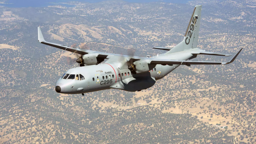

In [4]:
from fastdownload import download_url
dest = 'miliAirplane.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

> Verificamos se esta correto, então podemos baixar mais imagmes como exemplo.

In [7]:
searches = 'civil airplane', 'military airplane'
path = Path('civil_military')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'single engine {o}'))
    sleep(10)
    download_images(dest, urls=search_images(f'helicopter {o}'))
    sleep(10)
    download_images(dest, urls=search_images(f'jet propulsion {o}'))
    sleep(10)
    resize_images(path/o, max_size=400, dest= path/o)

Searching for 'single engine civil airplane'
Searching for 'helicopter civil airplane'
Searching for 'jet propulsion civil airplane'
Searching for 'single engine military airplane'
Searching for 'helicopter military airplane'
Searching for 'jet propulsion military airplane'


Foi utilizado o sleep para que não haja problemas no tráfego de informações.

> Essas imagens serão salvas em uma pasta cujo caminho está definido no path (civil_military).

# Passo 2: Treinamento



Antes de iniciar o treinamento do modelo de fato é necessário garantir que não haja imagens com erro para evitar futuros problemas:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para treinar um modelo, é necessário utilizar os DataLoaders, que são objetos que incluem um conjunto de treinamento (as imagens usadas para criar o modelo) e um conjunto de validação (as imagens usadas para verificar a precisão do modelo, mas que não são usadas durante o treinamento). No fastai, podemos criar esses DataLoaders de forma simples utilizando um DataBlock e também visualizar exemplos de imagens a partir deles.
lo.

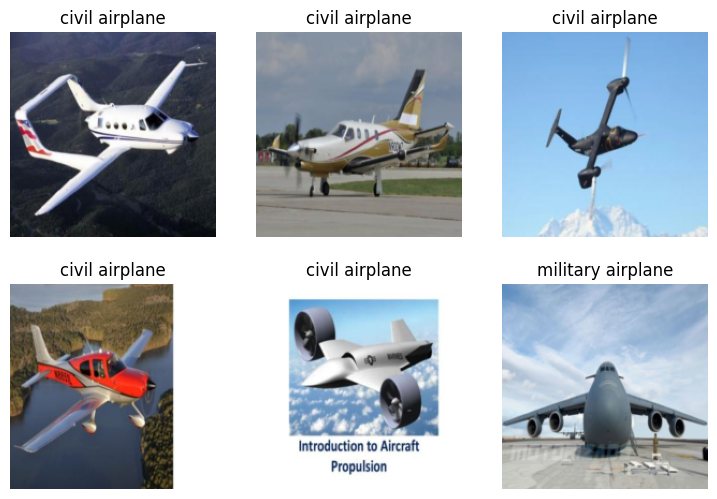

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # As entradas para o nosso modelo são imagens e as saídas são categorias
    get_items=get_image_files, # Retorna uma lista de todos os arquivos de imagem em um caminho.
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Divide os dados em conjuntos de treinamento e validação, 20% dos dados para validação.
    get_y=parent_label, # Os valores y são o nome do pai de cada arquivo (ou seja, o nome da pasta em que estão, que será pássaro ou floresta).
    item_tfms=[Resize(192, method='squish')] # Antes do treinamento, redimensione cada imagem para 192x192 pixels "espremendo-a" (em vez de cortá-la).
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o resnet50. Você pode treiná-lo em poucos minutos, mesmo em uma CPU! (Em uma GPU, geralmente leva menos de 10 segundos...)

O fastai vem com um método útil fine_tune() que automaticamente usa as melhores práticas para ajustar um modelo pré-treinado, então usaremos isso.

As duas células forçam a execução do garbage collector e do cache e tambem faz com que o output do resultado dos modelos treinados sejam exibidos corretamente. Basicamente limpando resultados de execuções antigas e lixo de memoria.

In [11]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

15403

In [12]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

# Passo 3: Treinando

Após criar o Datablock, o modelo é treinado com a ajuda do objeto "Learner". Ele é configurado com três argumentos: o primeiro é um DataLoader (dls) que contém o conjunto de dados de treinamento do modelo; o segundo é a arquitetura ResNet18 que será usada como base para o modelo; e o terceiro é a métrica usada para avaliar a performance do modelo, que neste caso é a taxa de erro.

Para realizar o ajuste fino do modelo, é utilizado o método "fine_tune()". Esse método realiza um treinamento adicional do modelo usando os pesos pré-treinados da ResNet18 como ponto de partida.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.564369,0.338985,0.141414,00:05
1,0.490396,0.254091,0.080808,00:05
2,0.443204,0.268272,0.080808,00:05
3,0.436753,0.306138,0.090909,00:04
4,0.437066,0.409041,0.070707,00:05
5,0.428458,0.220043,0.060606,00:05
6,0.399611,0.198123,0.070707,00:06
7,0.366052,0.244459,0.090909,00:05
8,0.333738,0.233485,0.090909,00:05
9,0.313968,0.229568,0.090909,00:05


Como visto acima obtemos uma taxa de erros de 09.09%.

# Testando o modelo

Com o modelo treinado, ao executar a última tela, receberá um prompt que informará o tipo de aeronave da pessoa na foto, a probabilidade de ser o tipo de aeronave previsto e a imagem inserida.

In [14]:
translator = {
    "civil airplane": "Avião Civil",
    "military airplane": "Avião Militar",
}

É um Avião Militar.
Probabilidade de ser do tipo Avião Militar: 96.90%


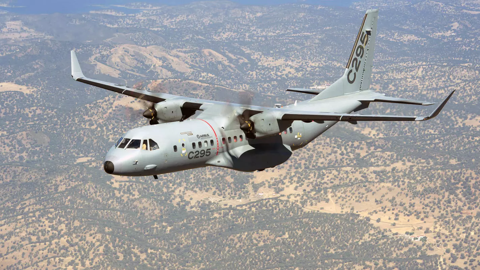

In [28]:
prediction_photo='miliAirplane.jpg'

airplane_type,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"É um {translator[airplane_type]}.")
print(f"Probabilidade de ser do tipo {translator[airplane_type]}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

# Conclusão
A utilização do fastai simplifica significativamente o processo de treinamento de modelos para reconhecimento de imagens. Minha principal dificuldade pessoal estava relacionada à linguagem utilizada, uma vez que não possuía conhecimento prévio nessa área. No entanto, aproveitei a primeira semana, mesmo antes de receber as instruções completas sobre como a disciplina funcionaria, para me concentrar na compreensão do Python. Depois de superar esse desafio inicial, fiquei muito satisfeito com o material disponibilizado e achei que ele proporcionou um excelente ponto de partida para minha jornada de aprendizado em machine learning. 
Contudo a IA tem um pouco de dificuldade de identificar aviões comerciais com propulsão a jato, acredito que o problema deriva se das imagens baixadas, é comum aparecer imagens apenas da turbina dificultando a diferenciação.


# Referências

> Jeremy Howard and Sylvain Gugge. FastBook. Disponível em https://github.com/fastai/fastbook. 
Acessado e 10 de Setembro de 2023.023

> Repositorio da Disciplina Disponível em https://github.com/fabraz/fastaiOnCampus. Acessado em 10 de Setembro de 2023.